# Cross-catalogue Comparison

This notebook performs Wesserstein and JS metrisc to models. The scores are saved to an Excel file and the scatter plots are created for visualization of overlaps.

In [7]:
%load_ext autoreload
%autoreload 2

In [120]:
# add grbttools to path
import sys

sys.path.append("../")

import warnings

# Turn off all warnings
warnings.filterwarnings("ignore")

In [49]:
from grbtools import metrics
from grbtools import models as md
from grbtools import metrics as mets
from grbtools import data as dt
from grbtools import disp
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
def predict_labels(feat_space, catalogue, n_components):
    loaded_model = md.load_model(
        catalog_name=catalogue, features=feat_space, n_components=n_components
    )
    loaded_data = dt.load_dataset(
        catalog_name=catalogue, features=feat_space, verbose=False
    )

    loaded_data["labels"] = loaded_model.predict(loaded_data)
    loaded_data["labels"] = loaded_data["labels"].astype(int)

    return loaded_data


def evaluate_cross_cat(save_file=False):
    feat_spaces = [["lgT90"], ["lgHrd"], ["lgT90", "lgHrd"]]
    _n_components = [2, 3, 4, 5]
    metric_defs = mets.get_comparison_metrics(verbose=False)
    scores = {
        "catalogue_1": [],
        "catalogue_2": [],
        "feature_space": [],
        "n_components": [],
        "cluster_no": [],
        "metric": [],
        "mean": [],
        "std": [],
    }

    for feat_space in feat_spaces:
        for n_components in _n_components:
            batse_pred = predict_labels(feat_space, "batse", n_components)
            fermi_pred = predict_labels(feat_space, "fermi", n_components)
            swift_pred = predict_labels(feat_space, "swift", n_components)

            for n in range(n_components):
                X_batse = batse_pred[batse_pred["labels"] == n].values
                X_fermi = fermi_pred[fermi_pred["labels"] == n].values
                X_swift = swift_pred[swift_pred["labels"] == n].values

                groupings = [X_batse, X_fermi, X_swift]
                namings = ["batse", "fermi", "swift"]

                for metric in metric_defs:
                    for i in range(len(groupings)):
                        for j in range(i + 1, len(groupings)):
                            scores["catalogue_1"].append(namings[i])
                            scores["catalogue_2"].append(namings[j])
                            scores["feature_space"].append("_".join(feat_space))
                            scores["n_components"].append(n_components)
                            scores["cluster_no"].append(n)
                            scores["metric"].append(metric)
                            calculated_metric = metric_defs[metric]["func"](
                                groupings[i], groupings[j]
                            )
                            scores["mean"].append(calculated_metric["mean"])
                            scores["std"].append(calculated_metric["std"])

    if save_file:
        df_scores = pd.DataFrame(scores)
        excel_file = "../models/cross_cat_scores.xlsx"
        df_scores.to_excel(excel_file, index=False)
        print("File has been saved.")

    return

In [130]:
evaluate_cross_cat()

In [117]:
def plot_cross_catalogue_2D(feat_space=None, n_components=None):
    
    batse_data = predict_labels(feat_space, "batse", n_components)
    fermi_data = predict_labels(feat_space, "fermi", n_components)
    swift_data = predict_labels(feat_space, "swift", n_components)


    if n_components != 1:
        n_rows = 3
        n_cols = n_components
        # create figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))

    else:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    groupings = [batse_data, fermi_data, swift_data]
    namings = ["BATSE", "FERMI", "SWIFT"]
    
    row = 0
    # plot models
    for i in range(len(groupings)):
        for j in range(i + 1, len(groupings)):
            for k in range(n_components):

                axes[row, k].scatter(
                    groupings[i][groupings[i]["labels"] == k].values[:, 0],
                    groupings[i][groupings[i]["labels"] == k].values[:, 1],
                    color=disp.get_color(i),
                    marker=disp.get_marker(i),
                    label=namings[i],
                    alpha=0.5,
                    s=50,
                )

                axes[row, k].scatter(
                    groupings[j][groupings[j]["labels"] == k].values[:, 0],
                    groupings[j][groupings[j]["labels"] == k].values[:, 1],
                    color=disp.get_color(j),
                    marker=disp.get_marker(j),
                    label=namings[j],
                    alpha=0.5,
                    s=50,
                )
            row +=1


    for i in range (n_cols):
        axes[0, i].set_title("Cluster " + str(i + 1), fontsize=15, fontweight="bold")

    fig.text(0.5, 0.05, feat_space[0], ha="center", fontsize=15)
    fig.text(0.05, 0.5, feat_space[1], va="center", rotation="vertical", fontsize=15)

    unique_labels = {}

    # Get handles and labels from all subplots
    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            if label not in unique_labels:
                handles.append(handle)
                labels.append(label)
                unique_labels[label] = True

    # Create a legend using the unique handles and labels
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=4,
        bbox_to_anchor=(0.5, 0.97),
        fontsize=10,
    )

    fig.text(0.5, 1, str(n_components) + "-Cluster", ha="center")



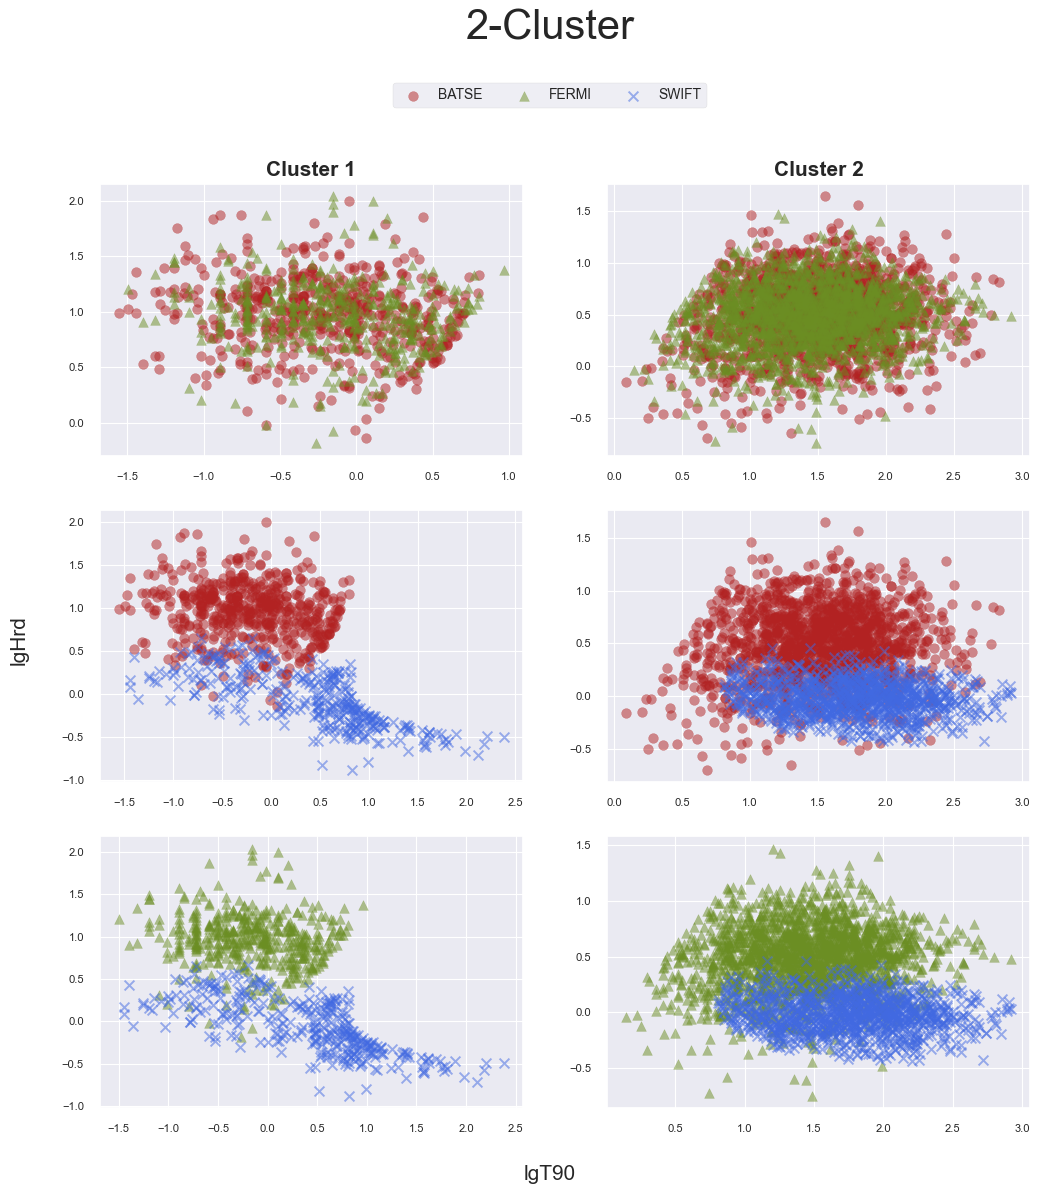

In [122]:
plot_cross_catalogue_2D(feat_space=["lgT90", "lgHrd"], n_components=2)

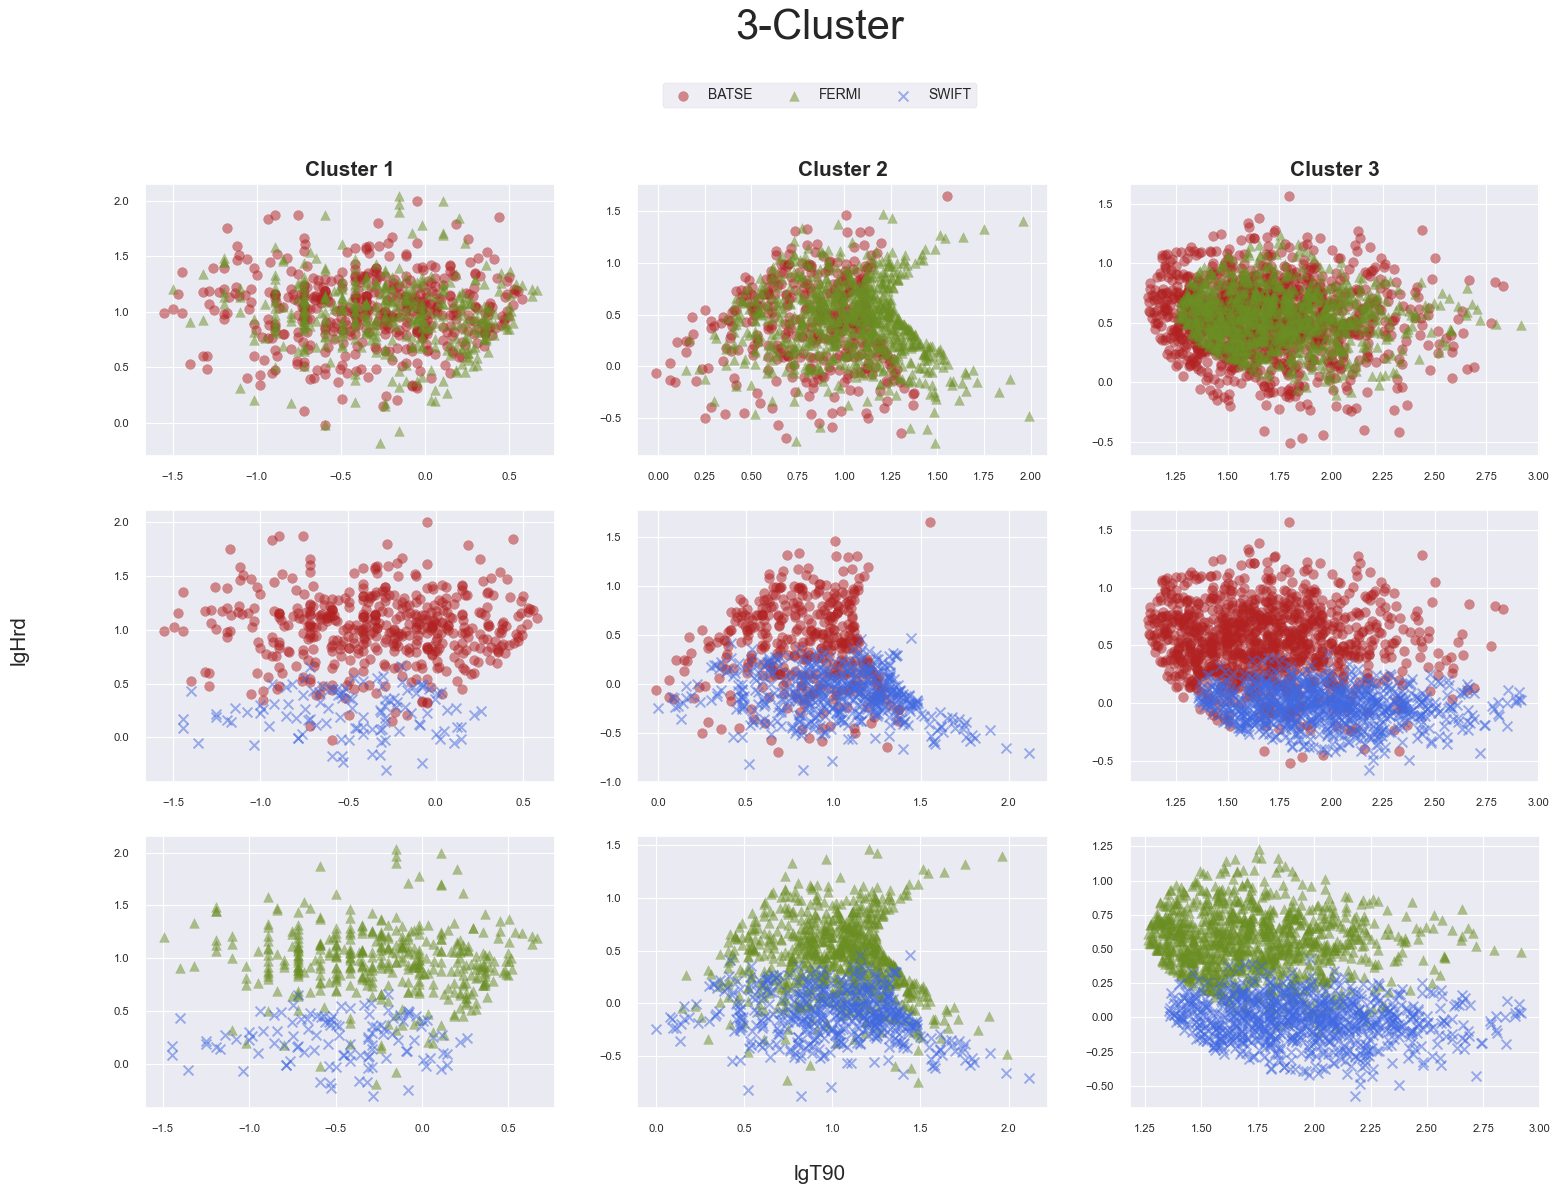

In [121]:
plot_cross_catalogue_2D(feat_space=["lgT90", "lgHrd"], n_components=3)

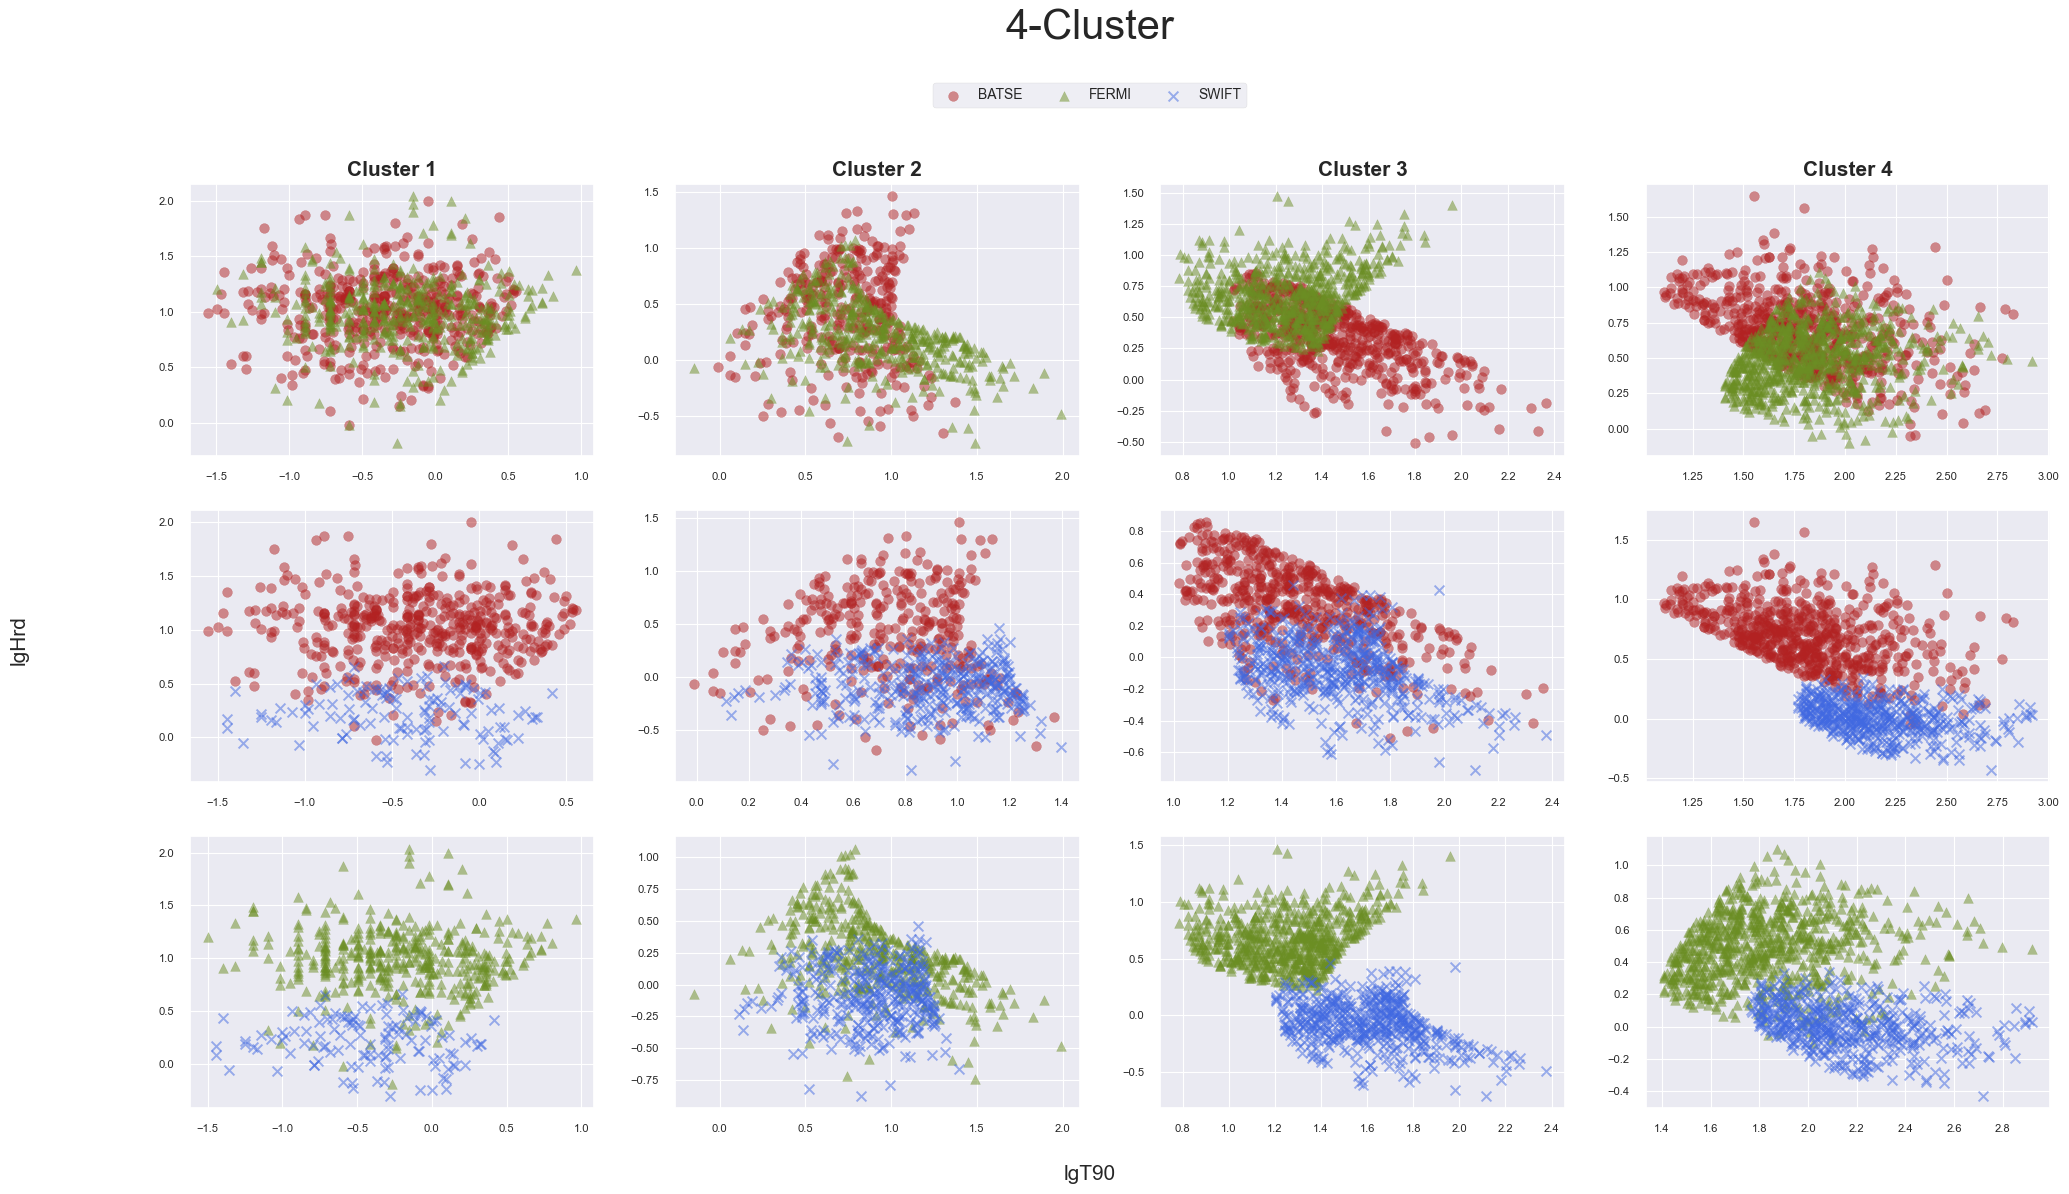

In [125]:
plot_cross_catalogue_2D(feat_space=["lgT90", "lgHrd"], n_components=4)

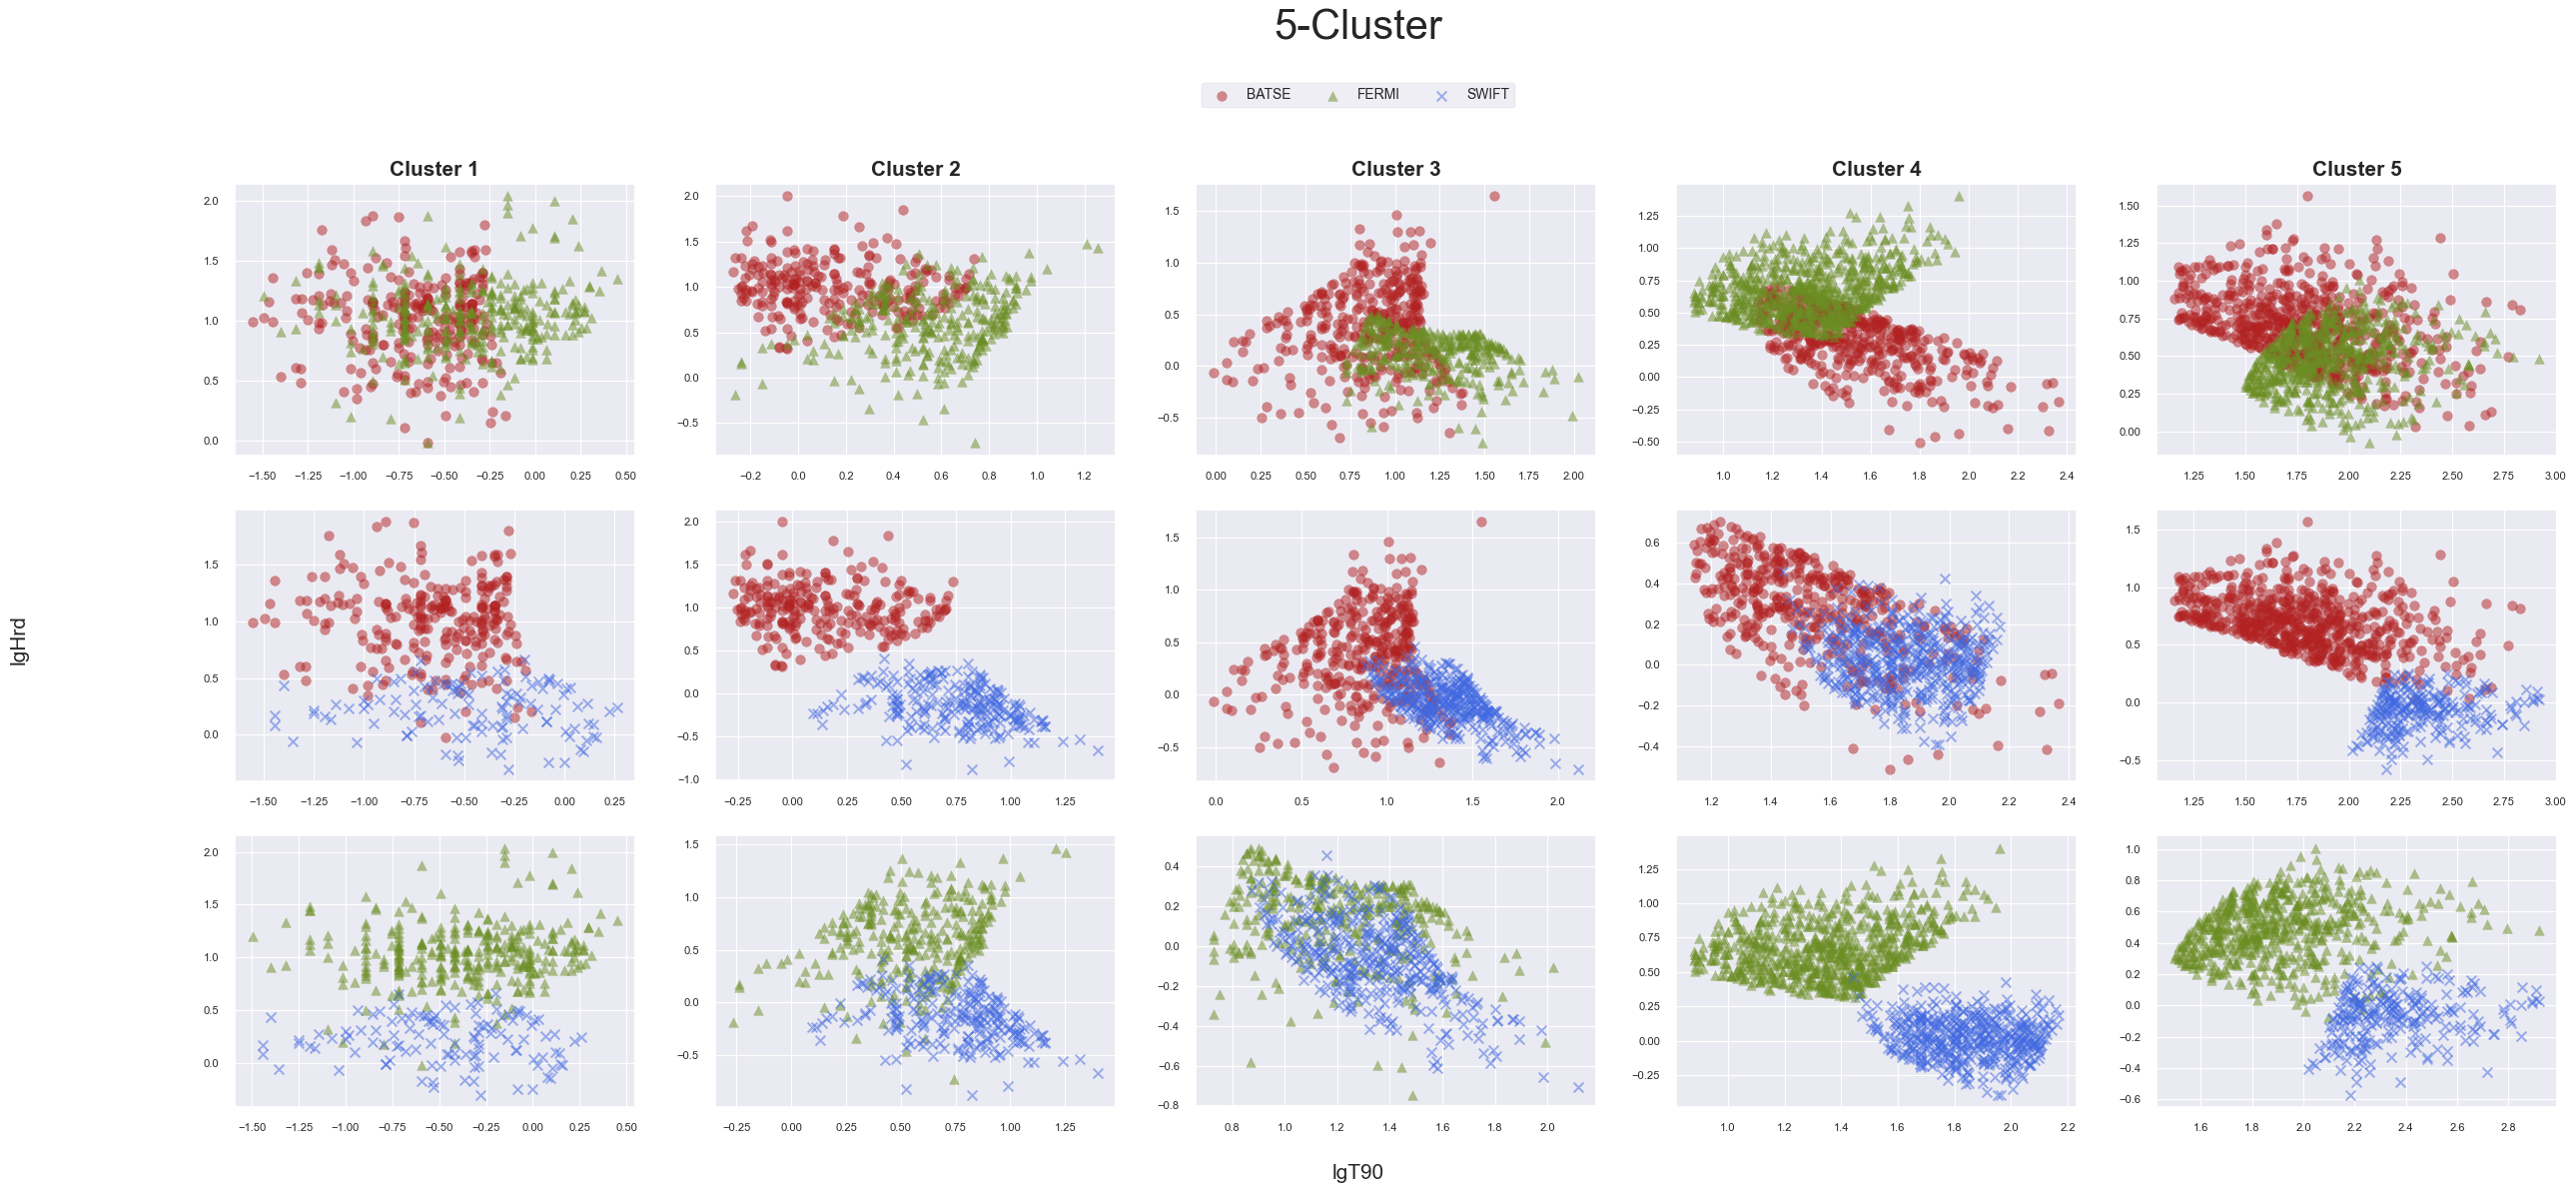

In [128]:
plot_cross_catalogue_2D(feat_space=["lgT90", "lgHrd"], n_components=5)